$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$


# CS236781: Deep Learning
# Tutorial 8: Sequence Models

## Introduction

In this tutorial, we will cover:

- What RNNs are and how they work
- Implementing basic RNNs models
- Application example: sentiment analysis of movie reviews
- Bonus: Stock prediction


In [1]:
# Setup
%matplotlib inline
import os
import sys
import time
import torch
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# pytorch
import torch
import torch.nn as nn
import torchtext
import torchtext.data as data
import torchtext.datasets as datasets
import torch.nn.functional as f

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory Reminders

Thus far, our models have been composed of fully connected (linear) layers or convolutional layers.

- Fully connected layers
    - Each layer $l$ operates on the output of the previous layer ($\vec{y}_{l-1}$) and calculates,
        $$
        \vec{y}_l = \varphi\left( \mat{W}_l \vec{y}_{l-1} + \vec{b}_l \right),~
        \mat{W}_l\in\set{R}^{n_{l}\times n_{l-1}},~ \vec{b}_l\in\set{R}^{n_l}.
        $$
    - FC's have completely pre-fixed input and output dimensions.
    
    <center><img src="img/mlp.png" width="600" /></center>

How can we model a dynamical system?
    <center><img src="https://raw.githubusercontent.com/mkimhi/cs3600-tutorials/bff05457bd30d5c798a6ec3bbc59d2ff23453eb2/T4/resources/rnn.gif" width="600" /></center>


E.g., a linear system such as

$$\vec{y}_t = a_0 + a_1 \vec{y}_{t-1}+\dots+a_P \vec{y}_{t-P} + b_0 \vec{x}_t+\dots+b_{t-Q}\vec{x}_{t-Q}$$

Many use cases and examples: signal processing, text translation, sentiment analysis, scene classification in video, etc.

## NLP Task summery


<center><img src="img/tasks.png" width="900" /></center>

#### A quick review of the Naive Bayes (NB) method for text classification:

input vector $\mathbf{x} = \langle x_1, x_2, \ldots, x_m \rangle$ of feature values, and a set of classes $\{ c_1, c_2, \ldots, c_k \}$ the text should be classified as. 

We will predict the class $c_i$ that maximizes $Pr(c_i \mid \mathbf{x})$.

By Bayes rule (this is the "Bayes" part in the name "Naive Bayes"), <br>

$$ argmax_i Pr(c_i | x) = argmax_i \frac{Pr(\mathbf{x} | c_i) \cdot Pr(c_i)}{Pr(\mathbf{x})} = argmax_i Pr(\mathbf{x} | c_i) \cdot Pr(c_i) $$

NB called like that because it used the bayes  rule, and because it's navie...assuming I.I.D, i.e:
$$  Pr(\mathbf{x} | c_i) =  \prod_{j=1}^m Pr(x_j | c_i) $$

Great, now we just need to think how we calculate the probabilities....
$$ Pr(x_j | c_i) \approx \frac{\# (x_j, c_i)}{\sum_k \# (x_k, c_i)} $$

This counting basic approch. is called **Bag Of Words (BOW)**.

in this approch, we count all the words in the document and use each one as a feature.
in general, expressing features as raw words is very easy to use with naive base.

<center><img src="https://raw.githubusercontent.com/mkimhi/cs3600-tutorials/main/T4/resources/bow.png" width="1000"/></center>


in this case, you probably see the problem right away.<br>
the strongest features are now very expresive.. 'the', ',' and 'very' doesn't say much about this review.<br>
this words exist both in good and bad reviews.<br>

that's why we need to express, not only the document frequncies, but also the general word frequncies.<br>
something like that is called **TF-IDF** as **Term frequency–inverse document frequency**<br>

<center><img src="https://raw.githubusercontent.com/mkimhi/cs3600-tutorials/main/T4/resources/tfidf.png" width="900"/></center>


where **TF** is the simplest cound we just did
and **IDF** usually define as $log(\frac{N}{Df_x})$ where N is the total documents and Df is the number of documents containing the term x.

in total we get $$\# (x_j, c_i) log(\frac{\sum_i \# (c_i)}{\sum_i \# (c_i,x_j)}) $$

and we solved one problem, however, order of words still matter and naive base, ever with smarter representation, is still naive in the notion of corrolation and order.

#### Now text generation, in a nutshell:

A model that predict the next token in a sentence, called **N-gram**.

recall that we have $m$ possible tokens in our corpus, we want to choose the word that maximize:
$$
Pr(x_n | x_1, x_2, ..., x_{n-1}) \approx \frac{\#{x_1, x_2, ..., x_n}}{\#{x_1, x_2, ..., x_{n-1}}}  = \frac{\#{x_1, x_2, ..., x_n}}{\sum_{x'} \#{x_1, x_2, ..., x_{n-1}, x'}}
$$

were the lenght of the sequnce that we depand on is the **N**.<br>

<center><img src="https://raw.githubusercontent.com/mkimhi/cs3600-tutorials/main/T4/resources/grams.png" width="900"/></center>



Now Let's dive into the components that we have in deep learning

## Recurrent layers

An RNN layer is similar to a regular FC layer, but it has two inputs:
- Current sample, $\vec{x}_t \in\set{R}^{d_{i}}$.
- Previous **state**, $\vec{h}_{t-1}\in\set{R}^{d_{h}}$.

and it produces two outputs which depend on both:
- Current layer output, $\vec{y}_t\in\set{R}^{d_o}$.
- Current **state**, $\vec{h}_{t}\in\set{R}^{d_{h}}$.

<center><img src="img/rnn_cell.png" width="400"/></center>

Crucially,
- The layer itself is not time-dependent (but is parametrized).
- The same layer (function) is applied at successive time steps, propagating the hidden state.

A basic RNN can be defined as follows.

$$
\begin{align}
\forall t \geq 0:\\
\vec{h}_t &= \varphi_h\left( \mat{W}_{hh} \vec{h}_{t-1} + \mat{W}_{xh} \vec{x}_t + \vec{b}_h\right) \\
\vec{y}_t &= \varphi_y\left(\mat{W}_{hy}\vec{h}_t + \vec{b}_y \right)
\end{align}
$$

where,
- $\vec{x}_t \in\set{R}^{d_{i}}$ is the input at time $t$.
- $\vec{h}_{t-1}\in\set{R}^{d_{h}}$ is the **hidden state** of a fixed dimension.
- $\vec{y}_t\in\set{R}^{d_o}$ is the output at time $t$.
- $\mat{W}_{hh}\in\set{R}^{d_h\times d_h}$, $\mat{W}_{xh}\in\set{R}^{d_h\times d_i}$, $\mat{W}_{hy}\in\set{R}^{d_o\times d_h}$, $\vec{b}_h\in\set{R}^{d_h}$ and $\vec{b}_y\in\set{R}^{d_o}$ are the model weights and biases.
- $\varphi_h$ and $\varphi_y$ are some non-linear functions. In many cases $\varphi_y$ is not used.

### Modeling time-dependence

If we imagine **unrolling** a single RNN layer through time,
<center><img src="img/rnn_unrolled.png" width="1200" /></center>

We can see how late outputs can now be influenced by early inputs, through the hidden state.

RNN models are very flexible in terms of input and output meaning.

Common applications include image captioning, sentiment analysis, machine translation and signal processing. 

<center><img src="img/rnn_use_cases.jpeg" width="1200"/></center>


How would **backpropagation** work, though?

<center><img src="img/bptt.png" width="1000"></center>

1. Calculated loss from each output and accumulate
2. Calculate Gradient of loss w.r.t. each parameter at each timestep
3. For each parameter, accumulate gradients from all timesteps

This is known as **Backpropagation through time**, or BPTT.

$$
\pderiv{L_t}{\mat{W}} = \sum_{k=1}^{t}
\pderiv{L_t}{\hat y_t} \cdot
\pderiv{\hat y_t}{\vec{h}_t} \cdot
\pderiv{\vec{h}_t}{\vec{h}_k} \cdot
\pderiv{\vec{h}_k}{\mat{W}}
$$

But how far back do we go? What's the limiting factor?

We're limited in depth by vanishing and exploding gradients controlled by the eigenvalues of $\mat{W}$.

One pragmatic solution is to limit the number of timesteps involved in the backpropagation.

<center><img src="img/tbptt.png" width="1000"></center>

This is known as **Truncated backpropagation through time**, or TBPTT.

### Gradient clipping
A popular method to avoid exploading gradients, is to use `gradients cliping`

the idea is super simple, yet efficient only for exploading and not for vanishing gradients

the idea is as such:
look at a layer $\matrix{L}$ with gradient matrix $\matrix{G}$

we would simply look at the norm of the gradients and when they exceed some threshold, we would clip it down.

i.e: if $\norm{\matrix{G}} \ge c$
$$
\matrix{G} = C \frac{\matrix{G}}{\norm{\matrix{G}}}
$$

and the process would look sort of like this:
<center><img src="https://raw.githubusercontent.com/mkimhi/cs3600-tutorials/main/T4/resources/clipping.PNG" width="1000"></center>

### Multi-layered (deep) RNN

RNNs layers can be stacked to build a deep RNN model.

<center><img src="img/rnn_layered.png" width="1200"/></center>

- As with MLPs, adding depth allows us to model intricate hierarchical features.
- However, now we also have a time dimension which makes the representation time-dependent.

## RNN Implementation

Based on the above equations, let's create a simple RNN layer  with PyTorch.

In [3]:
import torch.nn as nn

class RNNLayer(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, phi_h=torch.tanh, phi_y=torch.sigmoid):
        super().__init__()
        self.phi_h, self.phi_y = phi_h, phi_y
        
        self.fc_xh = nn.Linear(in_dim, h_dim, bias=False)
        self.fc_hh = nn.Linear(h_dim, h_dim, bias=True)
        self.fc_hy = nn.Linear(h_dim, out_dim, bias=True)
        
    def forward(self, xt, h_prev=None):
        if h_prev is None:
            h_prev = torch.zeros(xt.shape[0], self.fc_hh.in_features)
        
        ht = self.phi_h(self.fc_xh(xt) + self.fc_hh(h_prev))
        
        yt = self.fc_hy(ht)
        
        if self.phi_y is not None:
            yt = self.phi_y(yt)
        
        return yt, ht
        

We'll instantiate our model

In [4]:
N = 3 # batch size
in_dim, h_dim, out_dim = 1024, 10, 1

rnn = RNNLayer(in_dim, h_dim, out_dim)
rnn

RNNLayer(
  (fc_xh): Linear(in_features=1024, out_features=10, bias=False)
  (fc_hh): Linear(in_features=10, out_features=10, bias=True)
  (fc_hy): Linear(in_features=10, out_features=1, bias=True)
)

And manually "run" a few time steps

In [5]:
# t=1
x1 = torch.randn(N, in_dim, requires_grad=True) # requiring grad just for torchviz
y1, h1 = rnn(x1)
print(f'y1 ({tuple(y1.shape)}):\n{y1}')
print(f'h1 ({tuple(h1.shape)}):\n{h1}\n')

# t=2
x2 = torch.randn(N, in_dim, requires_grad=True)
y2, h2 = rnn(x2, h1)
print(f'y2 ({tuple(y2.shape)}):\n{y2}')
print(f'h2 ({tuple(h2.shape)}):\n{h2}\n')

y1 ((3, 1)):
tensor([[0.5117],
        [0.5224],
        [0.4770]], grad_fn=<SigmoidBackward>)
h1 ((3, 10)):
tensor([[-0.2625, -0.0464,  0.4600,  0.5016, -0.4945,  0.5016,  0.2303, -0.2902,
         -0.4289,  0.8829],
        [ 0.7519, -0.0690, -0.3956, -0.4167,  0.3975,  0.2174,  0.2782, -0.2484,
         -0.0332, -0.1904],
        [-0.6372, -0.2844, -0.4061, -0.0602,  0.7110,  0.0372,  0.1477, -0.8718,
          0.2926, -0.0308]], grad_fn=<TanhBackward>)

y2 ((3, 1)):
tensor([[0.4526],
        [0.4947],
        [0.5258]], grad_fn=<SigmoidBackward>)
h2 ((3, 10)):
tensor([[ 0.5555,  0.3156, -0.2389,  0.5042,  0.4184,  0.7893,  0.4086, -0.9184,
          0.5087, -0.0985],
        [-0.3544, -0.0399,  0.4257, -0.2183, -0.4118,  0.5009,  0.0786,  0.3468,
         -0.4978,  0.4522],
        [ 0.0467, -0.0896, -0.3171, -0.1893,  0.3009,  0.5974, -0.3587, -0.0171,
         -0.1279,  0.5574]], grad_fn=<TanhBackward>)



As usual, let's visualize the computation graph and see what happened when we used the same RNN block twice, by looking at the graph from both $y_1$ and $y_2$.

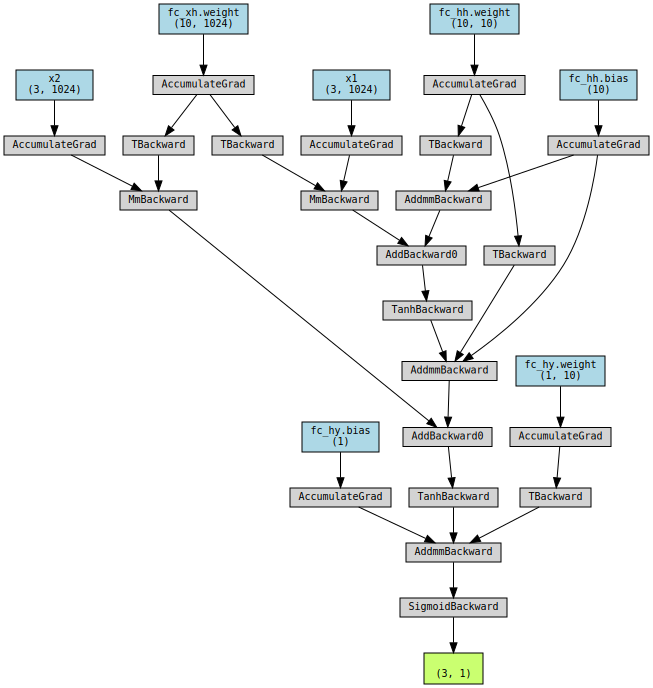

In [6]:
import torchviz

torchviz.make_dot(
    y2, # Note: Change here to y2 to see the fullly unrolled graph!
    params=dict(list(rnn.named_parameters()) + [('x1', x1), ('x2', x2)])
)

## LSTM and GRU


We talked about the vanishing gradients problem with RNN, however, we didn't mention how to deal with those.
Luckyly, Gradient based methods invented long time ago...
Today we will talk about **Long Short term Memory (LSTM)** and **Gated Recurrent Unit (GRU)**. <br>

both are a type of recurrent cell that tries to preserve long term information. The idea of LSTM was presented back in 1997, but flourished in the age of deep learning.

The cell have `memory` or `context` that's base on the `state` of basic RNN and on 3 main gates: 

- Input gate: decides when to read data into the cell.
- Output gate: outputs the entries from the cell.
- Forget gate: a mechanism to reset the content of the cell.
These gates learn which information is relevant to forget or remember during the training process. The gates contain a non-linear activision function (sigmoid).


* we denote the input  $X_t \in \mathbb{R}^{n\times d}$ at timestemp $t$ and the hidden state of the previous time step is $H_{t−1}\in \mathbb{R}^{n\times h}$.



<center><img src="https://raw.githubusercontent.com/mkimhi/cs3600-tutorials/main/T4/resources/LSTM.PNG" width="800" /></center>


- **Forget gate**: $$ F_t = \sigma(X_tW_{xf} +H_{t-1}W_{hf} +b_f) \in \mathbb{R}^{n\times f}, $$
- **Input gate**: $$ I_t = \sigma(X_tW_{xi} +H_{t-1}W_{hi} +b_i) \in \mathbb{R}^{n\times h},$$
- **Output gate**: $$ O_t = \sigma(X_tW_{xo} +H_{t-1}W_{ho} +b_o) \in \mathbb{R}^{n\times o}, $$

- **candidate memory**:$$ \tilde{C}_t = \text{tanh}(X_tW_{xc} +H_{t-1}W_{hc} +b_c) \in \mathbb{R}^{n\times c}$$

- **memory / context**: $$ C_t = F_t \odot C_{t-1} + I_{t} \odot \tilde{C}_t$$
 
- **hidden state**: $$ H_t = O_t \odot \text{tanh}(C_t)$$


as you can see, we save 2 diffrent states, `hidden` and `context` (and of course it's not mentioned, but we have the output as well).

the idea really help with vanishing gradients, yet a big set of weights is added to the simple RNN.

In [7]:
lstm = nn.LSTM(10, 20, 2) #LSTM is not an encoder decoder, thus we can project the output size, but default we use the hidden size
input = torch.randn(5, 3, 10) #5 batch size, seq of 3, input dim 10

h0 = torch.randn(2, 3, 20) #2 for 2 layers of the LSTM
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = lstm(input, (h0, c0))

print('input shape =',input.shape)
print('hidden shape =',h0.shape)
print('output shape =',output.shape)

input shape = torch.Size([5, 3, 10])
hidden shape = torch.Size([2, 3, 20])
output shape = torch.Size([5, 3, 20])


We now have 8 sets of weights to learn (i.e., the U and W for each of the 4
gates within each unit), whereas with simple recurrent units we only had 2. Training
these additional parameters imposes a much significantly higher training cost. 

**Gated Recurrent Unit** or **GRU** ease this burden by dispensing with the
use of a separate context vector, and by reducing the number of gates to 2 — a reset gate, r and an update gate, z.

<center><img src="https://raw.githubusercontent.com/mkimhi/cs3600-tutorials/main/T4/resources/gru_1.svg" width="700" /></center>

- **reset gate**:
$$ R_t = \sigma(X_tW_{xr} + H_{t-1}W_{hr} +b_r) \in \mathbb{R}^{n \times h}$$
- **update gate**:
$$ Z_t = \sigma(X_tW_{xz} + H_{t-1}W_{hz} +b_z) \in \mathbb{R}^{n \times h} $$

- **candidate hidden state**: 
 $$ \tilde{H}_{t} = \text{tanh}\left(X_t W_{xh} + (R_t \odot H_{t-1})W_{hh} \right) + b_h$$
- **hidden state**:
$$ H_t = Z_t \odot H_{t-1} +(1-Z_t) \odot \tilde{H}_t. $$


* Whenever the update gate $Z_t$ is close to 1, we simply retain the old state. In this case the information from $X_t$ is essentially ignored, effectively skipping time step $t$ in the dependency chain. 
* In contrast, whenever $Z_t$ is close to 0, the new latent state $H_t$ approaches the candidate latent state $\tilde{H}_t$.
* These designs can help us cope with the vanishing gradient problem in RNNs and better capture dependencies for sequences with large time step distances.

In [39]:
def num_params(layer):
    return sum([p.numel() for p in layer.parameters()])

rnn = nn.RNN(10, 2, 2)
lstm = nn.LSTM(10, 2, 2)
gru = nn.GRU(10,2,2)
print(f'RNN params: {num_params(rnn)}')
print(f'LSTM params: {num_params(lstm)}')
print(f'GRU params: {num_params(gru)}')

RNN params: 40
LSTM params: 160
GRU params: 120


## Part 1: Sentiment analysis for movie reviews

The task: Given a review about a movie written by some user, decide whether it's **positive**, **negative** or **neutral**.

<center><img src="img/sentiment_analysis.png" width="500" /></center>


Classically this is considered a challenging task if approached based on keywords alone.

Consider:

     "This movie was actually neither that funny, nor super witty."
     
To comprehend such a sentence, it's intuitive to see that some "state" must be kept when "reading" it.

### Dataset

We'll use the [`torchtext`](https://github.com/pytorch/text) package, which provides useful tools for working ith textual data, and also includes some built-in datasets and dataloaders (similar to `torchvision`).

Out dataset will be the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/treebank.html) (SST) dataset, which contains ~10,000 **labeled** movie reviews.

The label of each review is either "positive", "neutral" or "negative".


#### Loading and tokenizing text samples

The `torchtext.data.Field` class takes care of splitting text into unique "tokens"
(~words) and converting it a numerical representation as a sequence of numbers representing
the tokens in the text.

In [9]:
import torchtext.data

# torchtext Field objects parse text (e.g. a review) and create a tensor representation

# This Field object will be used for tokenizing the movie reviews text
# For this application, tokens ~= words

review_parser = torchtext.data.Field(
    sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long,
    tokenize='spacy', tokenizer_language='en_core_web_sm'
)

# This Field object converts the text labels into numeric values (0,1,2)
label_parser = torchtext.data.Field(
    is_target=True, sequential=False, unk_token=None, use_vocab=True
)

In [10]:
import torchtext.datasets

# Load SST, tokenize the samples and labels
# ds_X are Dataset objects which will use the parsers to return tensors
ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(
    review_parser, label_parser, root=data_dir
)

n_train = len(ds_train)
print(f'Number of training samples: {n_train}')
print(f'Number of test     samples: {len(ds_test)}')

downloading trainDevTestTrees_PTB.zip


.pytorch-datasets\sst\trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:02<00:00, 267kB/s]  


extracting
Number of training samples: 8544
Number of test     samples: 2210


Lets print some examples from our training data:

In [11]:
for i in ([111, 4321, 7777, 0]):
    example = ds_train[i]
    label = example.label
    review = str.join(" ", example.text)
    print(f'sample#{i:04d} [{label:8s}]:\n > {review}\n')

sample#0111 [positive]:
 > the film aims to be funny , uplifting and moving , sometimes all at once .

sample#4321 [neutral ]:
 > the most anti - human big studio picture since 3000 miles to graceland .

sample#7777 [negative]:
 > an ugly , revolting movie .

sample#0000 [positive]:
 > the rock is destined to be the 21st century 's new ` ` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean - claud van damme or steven segal .



#### Building a vocabulary

The `Field` object can build a **vocabulary** for us,
which is simply a bi-directional mapping between a unique index and a token.

We'll only include words from the training set in our vocabulary.

In [12]:
review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

print(f"Number of tokens in training samples: {len(review_parser.vocab)}")
print(f"Number of tokens in training labels: {len(label_parser.vocab)}")

Number of tokens in training samples: 15492
Number of tokens in training labels: 3


In [13]:
print(f'first 20 tokens:\n', review_parser.vocab.itos[:20], end='\n\n')

first 20 tokens:
 ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'the', ',', 'a', 'and', 'of', 'to', '-', 'is', "'s", 'it', 'that', 'in', 'as', 'but', 'film']



Note the **special tokens**, `<unk>`, `<pad>`, `<sos>` and `<eos>` at indexes `0-3`.
These were automatically created by the tokenizer.

In [14]:
# Show that some words exist in the vocab
for w in ['film', 'actor', 'schwarzenegger', 'spielberg']:
    print(f'word={w:15s} index={review_parser.vocab.stoi[w]}')

word=film            index=19
word=actor           index=494
word=schwarzenegger  index=3406
word=spielberg       index=717


In [15]:
print(f'labels vocab:\n', dict(label_parser.vocab.stoi))

labels vocab:
 {'positive': 0, 'negative': 1, 'neutral': 2}


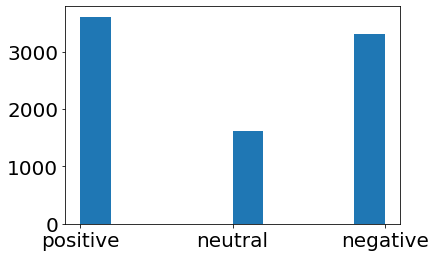

In [16]:
hist = [ds_train[i].label for i in range(len(ds_train))]
plt.hist(hist);

#### Data loaders (iterators)

The `torchtext` package comes with `Iterator`s, similar to the `DataLoaders` we previously worked with.

A key issue when working with text sequences is that each sample is of a different length.

So, how can we work with **batches** of data?

In [17]:
BATCH_SIZE = 4

# BucketIterator creates batches with samples of similar length
# to minimize the number of <pad> tokens in the batch.
dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)

Lets look at a single batch.

In [45]:
batch = next(iter(dl_train))

X, y = batch.text, batch.label
print('X = \n', X, X.shape, end='\n\n')
print('y = \n', y, y.shape)

X = 
 tensor([[    2,     2,     2,     2],
        [    7,    84,    14,     7],
        [  252,   688,    13,  7124],
        [   19,    21,  3204,   168],
        [    4,  3242,   660,    11],
        [    3,    11,     6,  1551],
        [    1,     7,   577,    15],
        [    1, 15150,    45,   328],
        [    1,  2497,   305,    39],
        [    1,    22,    15,    74],
        [    1,    95,    13,   805],
        [    1,    76,    91,   783],
        [    1,  4686,   323,   425],
        [    1,    30,   215,  2857],
        [    1,    84,     8,    20],
        [    1,  7989,  2955,   434],
        [    1,    21,   943,     7],
        [    1,   715,    16,   272],
        [    1, 12149,   886,     9],
        [    1,     9,     9,   691],
        [    1,     5,    56,   515],
        [    1,  6805,    14,     7],
        [    1,   466,    13,   252],
        [    1,     4,   363,   449],
        [    1,     3,    10,    21],
        [    1,     1,    88,   140],
      

What are we looking at?

Our sample tensor `X` is of shape `(sentence_length, batch_size)`.

Note that:
1. `sentence_length` changes every batch! You can re-run the previous block to see this.
2. Sequence dimension first (not batch). When we implement the model, you'll see why it's easier to work this way.

### Model

We'll now create our sentiment analysis model based on the simple `RNNLayer` we've implemented above.

The model will:
- Take an input batch of tokenized sentences.
- Compute a dense word-embedding of each token.
- Process the sentence **sequentially** through the RNN layer.
- Produce a `(B, 3)` tensor, which we'll interpret as class probabilities for each sentence in the batch.

What is a **word embedding**? How do we get one?

Embeddings encode tokens as tensors in a way that maintain some **semantic** meaning for our task.

<center><img src="img/word_embeddings.png" width="700"/></center>

### How we embed:

1. Embedding Layer: We train an embeding layer with our desired size, take a long time and require a lot of data, but learn the specific relations in our corpus


2. Word2Vec: statistical method for efficiently learning a standalone word embedding from a text corpus. it's based on CBOW (continues bag of words) and C-SKIP-GRAM (continues skip-gram).


3. GloVe (Global Vectors for Word Representation):extension to the word2vec method for efficiently learning word vectors. using matrix factorization techniques such as Latent Semantic Analysis (LSA). if Word2Vec use a window to determine the context, GloVe used the statistics of a word to accure in the hole text.



Here we'll train an Embedding together with our model:

In [19]:
embedding_layer = nn.Embedding(num_embeddings=5, embedding_dim=8)

token_idx = torch.randint(low=0, high=5, size=(6,))
print(token_idx)
embedding_layer(token_idx)

tensor([0, 0, 0, 4, 3, 4])


tensor([[-0.6148,  0.4295,  0.2688, -1.2557, -0.2909,  0.1137, -0.6538, -0.4554],
        [-0.6148,  0.4295,  0.2688, -1.2557, -0.2909,  0.1137, -0.6538, -0.4554],
        [-0.6148,  0.4295,  0.2688, -1.2557, -0.2909,  0.1137, -0.6538, -0.4554],
        [ 1.0616,  1.5287,  0.7757, -0.9666, -0.5960,  0.5966, -1.3547, -0.0375],
        [ 0.4897, -0.8420,  0.1922,  0.2192, -0.7601, -0.3931,  0.0613,  1.2560],
        [ 1.0616,  1.5287,  0.7757, -0.9666, -0.5960,  0.5966, -1.3547, -0.0375]],
       grad_fn=<EmbeddingBackward>)

OK, model time:

In [20]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, h_dim, out_dim):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        
        # Our own Vanilla RNN layer, without phi_y so it outputs a class score
        self.rnn = RNNLayer(in_dim=embedding_dim, h_dim=h_dim, out_dim=out_dim, phi_y=None)
        
        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        # X shape: (S, B) Note batch dim is not first!
        
        embedded = self.embedding(X) # embedded shape: (S, B, E)
        
        # Loop over (batch of) tokens in the sentence(s)
        ht = None
        for xt in embedded:           # xt is (B, E)
            yt, ht = self.rnn(xt, ht) # yt is (B, D_out)
        
        # Class scores to log-probability
        yt_log_proba = self.log_softmax(yt)
        
        return yt_log_proba

Let's instantiate our model.

In [21]:
INPUT_DIM = len(review_parser.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3

model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model

SentimentRNN(
  (embedding): Embedding(15492, 100)
  (rnn): RNNLayer(
    (fc_xh): Linear(in_features=100, out_features=128, bias=False)
    (fc_hh): Linear(in_features=128, out_features=128, bias=True)
    (fc_hy): Linear(in_features=128, out_features=3, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

Test a manual forward pass:

In [22]:
print(f'model(X) = \n', model(X), model(X).shape)
print(f'labels = ', y)

model(X) = 
 tensor([[-1.0548, -1.5795, -0.8082],
        [-1.0548, -1.5795, -0.8082],
        [-0.9473, -0.9190, -1.5450],
        [-1.0548, -1.5795, -0.8082]], grad_fn=<LogSoftmaxBackward>) torch.Size([4, 3])
labels =  tensor([0, 0, 0, 1])


How big is our model?

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The RNN model has {count_parameters(model):,} trainable weights.')

The RNN model has 1,578,899 trainable weights.


Why so many? We used only one RNN layer.

Where are most of the weights?

### Training

Let's complete the example by showing the regular pytorch-style train loop with this model.

We'll run only a few epochs on a small subset just to test that it works.

In [24]:
def train(model, optimizer, loss_fn, dataloader, max_epochs=100, max_batches=200):
    for epoch_idx in range(max_epochs):
        total_loss, num_correct = 0, 0
        start_time = time.time()

        for batch_idx, batch in enumerate(dataloader):
            X, y = batch.text, batch.label

            # Forward pass
            y_pred_log_proba = model(X)

            # Backward pass
            optimizer.zero_grad()
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == max_batches-1:
                break
                
        print(f"Epoch #{epoch_idx}, loss={total_loss /(max_batches):.3f}, accuracy={num_correct /(max_batches*BATCH_SIZE):.3f}, elapsed={time.time()-start_time:.1f} sec")

In [25]:
import torch.optim as optim

rnn_model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

# Recall: LogSoftmax + NLL is equiv to CrossEntropy on the class scores
loss_fn = nn.NLLLoss()

train(rnn_model, optimizer, loss_fn, dl_train, max_epochs=4) # just a demo

Epoch #0, loss=1.079, accuracy=0.426, elapsed=8.4 sec
Epoch #1, loss=1.058, accuracy=0.446, elapsed=7.5 sec
Epoch #2, loss=1.049, accuracy=0.436, elapsed=6.9 sec
Epoch #3, loss=1.032, accuracy=0.441, elapsed=7.7 sec


In [26]:
from sklearn import metrics

def print_stats(model, dataloader):
    model.eval() # put in evaluation mode
    trues = []
    preds = []
    with torch.no_grad():
        for data in dataloader:
            X, y = data.text.to(device), data.label.to(device)
            trues+=list(y.cpu())
            y_pred_log_proba = model(X)
            predicted = torch.argmax(y_pred_log_proba, dim=1)
            preds+= list(predicted.cpu())            
    print(metrics.classification_report(trues, preds, digits=3))
    
print_stats(rnn_model, dl_train)

              precision    recall  f1-score   support

           0      0.424     0.287     0.342      3610
           1      0.382     0.705     0.495      3310
           2      0.000     0.000     0.000      1624

    accuracy                          0.394      8544
   macro avg      0.269     0.330     0.279      8544
weighted avg      0.327     0.394     0.336      8544



#### Limitations

As usual this is a very naïve model, just for demonstration.
It lacks many tricks of the NLP trade, such was pre-trained embeddings,
gated RNN units, deep or bi-directional models, dropout, etc.

Don't expect SotA results :)

## Part 2: Time-Series Forecasting: Predicting Stock Prices Using An LSTM Model

Now we learned how to work with words and documents, how about making money by forecasting in NASDAQ?

as a disclaimer, i will try to explain, why it's nearly impossible to beat the market, but it's still a great tool to be familiar with, and who knows, maybe you would think out of the box and beat the market, just don't forget to tip your favorit T.A after :)

**this is the oposite of a recomandation to invest with predicting the price of stocks**

we will run this section regardless on the tutorial, so we're going to import all libraries again...

note that `alpha_vantage` just help us to get the stocks data from https://www.alphavantage.co/.

if you don't want it as part of your enviroment, just use `conda update` with the json file again...

**this is also not a recommandation to use alpha_vantage API, it's you can use yahoo database from pandas or whatever other API, or even scrape the data yourself**

In [27]:
! pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

now we need to determine some parameters, and we're going to use a dictionary config for that.<br>
when usually we deal only with batch size and learning rate, here we devide the keys to some sections (so we actually have a dict of dicts)<br>
- **alpha_vantage**: what params we want to use (here we use only the closing price and only IBM symbole)
- **data**: we determine window size, as the input seq len for the model and the split size for train and validation
- **plots**: just some parameters for the plots
- **model**: some model params
- **training**: some parameters for the training process

In [28]:
config = {
    "alpha_vantage": {
        "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",   #can use APPL or anything you would like
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 4,
        "train_split_size": 0.90,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Number data points: 5926 from 1999-11-01 to 2023-05-19


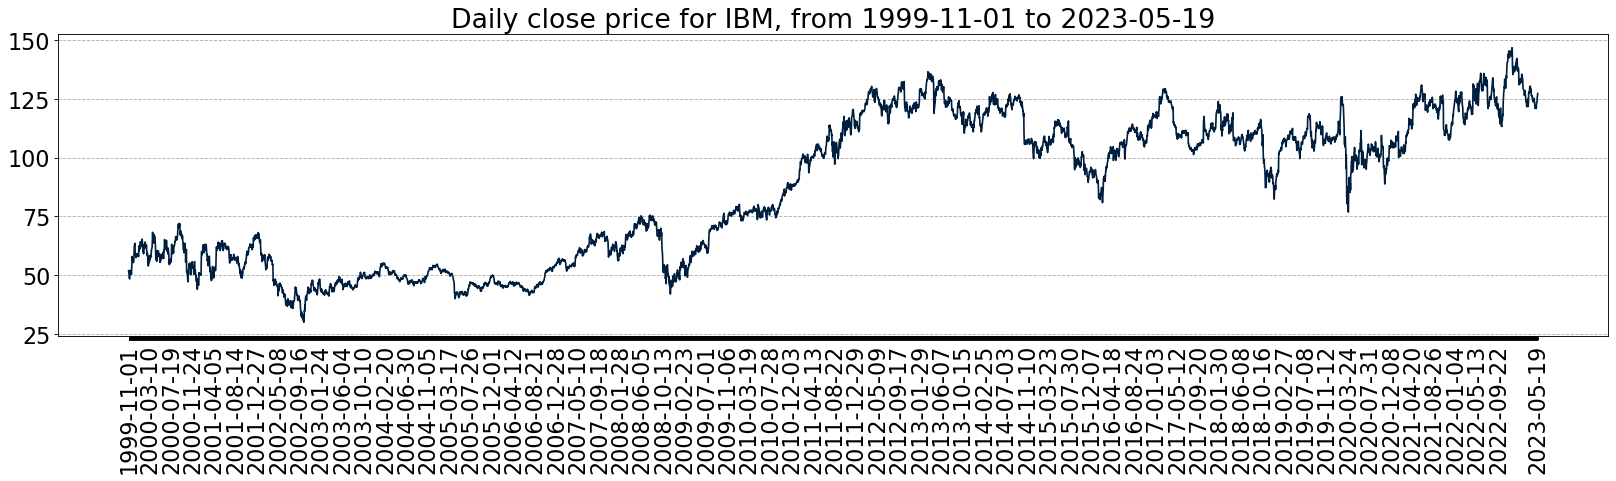

In [29]:
def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

In [30]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

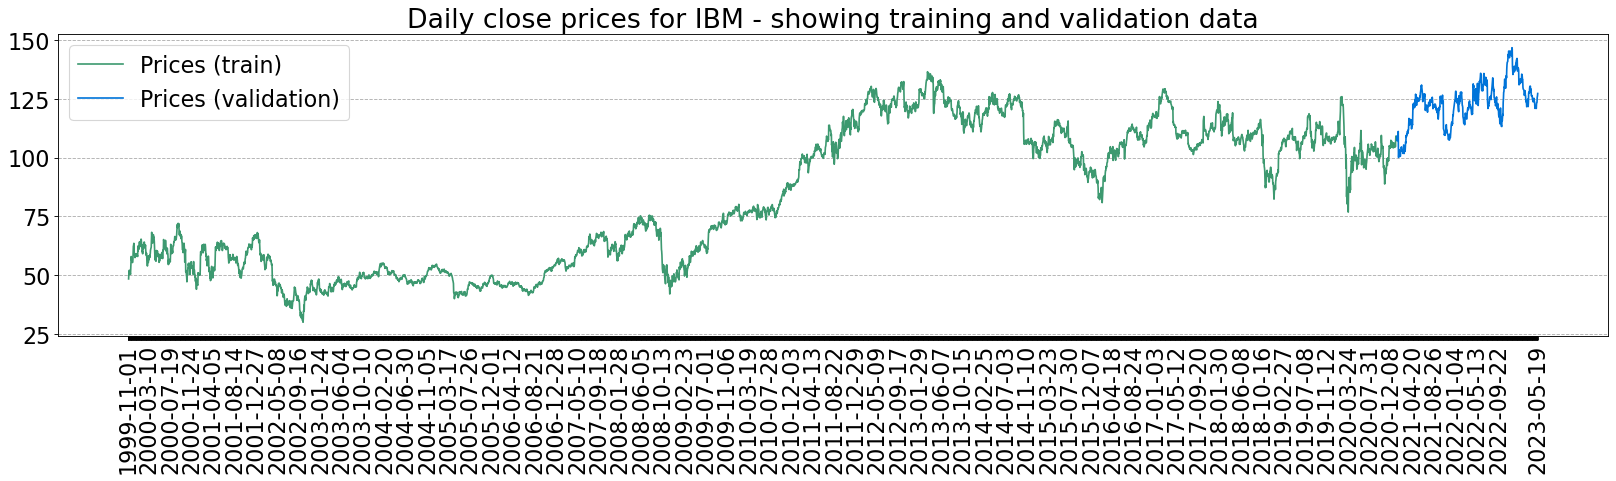

In [31]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    #even easier, use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

In [32]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for the model
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (5329, 4, 1) (5329,)
Validation data shape (593, 4, 1) (593,)


In [33]:
class GRU_stocks_Model(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.gru.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        #gru
        #if you choose to use lstm:
        #lstm_out, (h_n, c_n) = self.lstm(x)
        gru_out, h_n = self.gru(x)
        
        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

stocks_Model = GRU_stocks_Model(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
stocks_Model = stocks_Model.to(config["training"]["device"])

In [34]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        stocks_Model.train()
    else:
        stocks_Model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = stocks_Model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(stocks_Model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    if epoch%10 ==0:
        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
                  .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


Epoch[1/100] | loss train:0.064191, test:0.001429 | lr:0.010000
Epoch[11/100] | loss train:0.009261, test:0.000894 | lr:0.010000
Epoch[21/100] | loss train:0.009937, test:0.000945 | lr:0.010000
Epoch[31/100] | loss train:0.008934, test:0.000717 | lr:0.010000
Epoch[41/100] | loss train:0.008045, test:0.001254 | lr:0.001000
Epoch[51/100] | loss train:0.007277, test:0.000592 | lr:0.001000
Epoch[61/100] | loss train:0.007448, test:0.000833 | lr:0.001000
Epoch[71/100] | loss train:0.007293, test:0.000655 | lr:0.001000
Epoch[81/100] | loss train:0.007272, test:0.000689 | lr:0.000100
Epoch[91/100] | loss train:0.007354, test:0.000672 | lr:0.000100


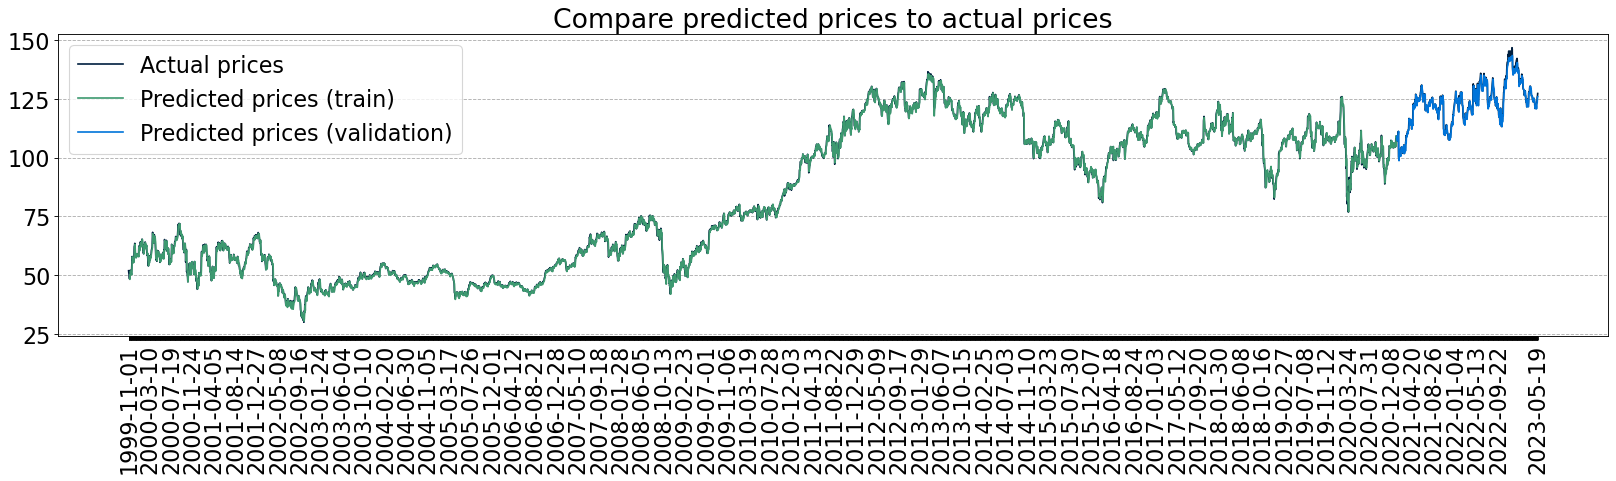

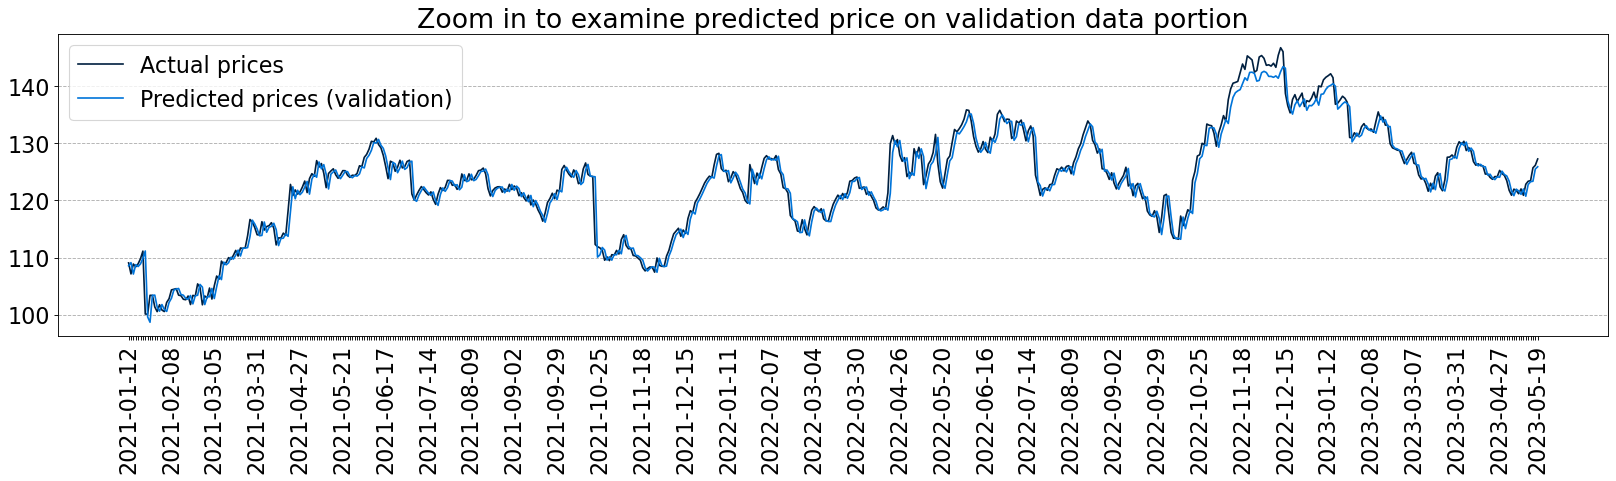

In [35]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

stocks_Model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = stocks_Model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = stocks_Model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

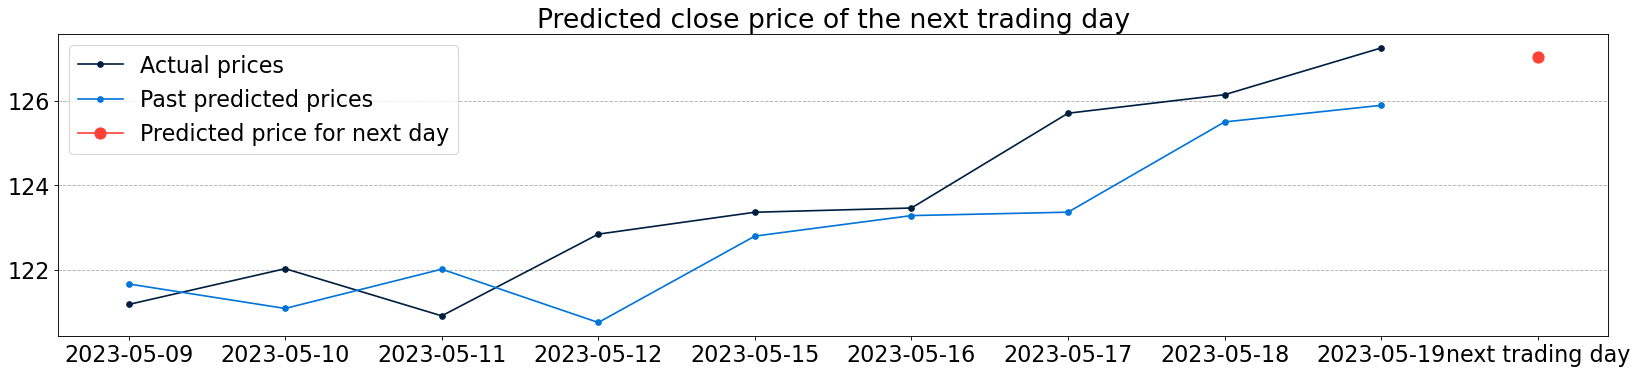

Predicted close price of the next trading day: 127.05


In [36]:
# predict on the unseen data, tomorrow's price 

stocks_Model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = stocks_Model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

#### Thanks!

**Credits**

This tutorial was written by [Moshe Kimhi](https://www.linkedin.com/in/moshekimhi/) and [Aviv A. Rosenberg](https://avivr.net).<br>
To re-use, please provide attribution and link to the original.

Some images in this tutorial were taken and/or adapted from the following sources:

- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017
- Sebastian Ruder, "On word embeddings - Part 1", 2016, https://ruder.io
- Andrej Karpathy, http://karpathy.github.io
- MIT 6.S191
- Stanford cs231n
- S. Bai et al. 2018, http://arxiv.org/abs/1803.01271